# RGI09 (Russian Arctic)

F. Maussion & S. Galos

Same outlines as in RGI6.

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 9

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '09_rgi60_RussianArctic.zip')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
567,1069,51591.5,Moholdt,Koenig,2013,"Svalbard, Jan Mayen, and Bouvet",2002,2000,2010
671,1474,22390.1,Paul,Paul,2017,Various (GlobGlacier),2016,2013,2016
694,1510,12370.7,"Paul, Rastner, Schaub",Paul,2018,Various (GlobGlacier),2016,2016,2016


In [5]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

In [6]:
# For this region RGI07 shall be equal to RGI06 so...
#...extract RGI06 from GLIMS by 'subm_id' 567 which refers to data by Moholdt et al. 2012
rgi7 = shp.loc[shp['subm_id']== 567].copy()
rgi7['is_rgi6'] = True

### Some sanity checks 

In [7]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
567,1069,1069


In [8]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

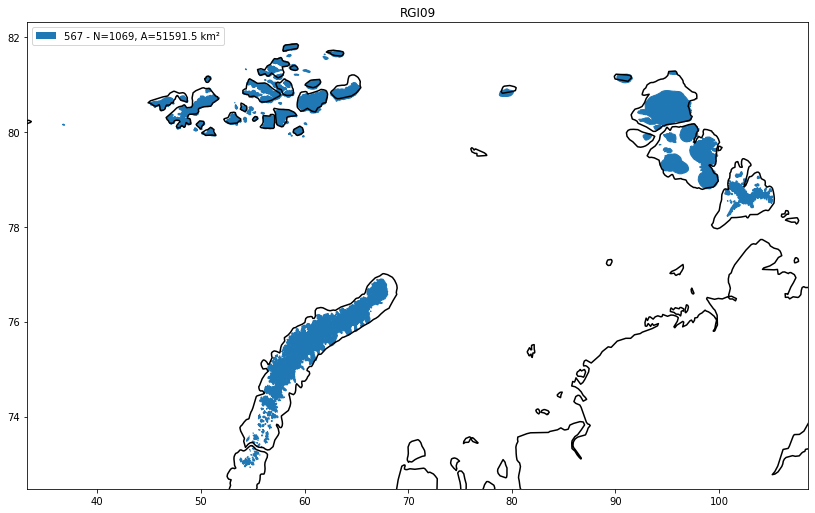

In [9]:
plot_map(rgi7, reg, loc='upper left')

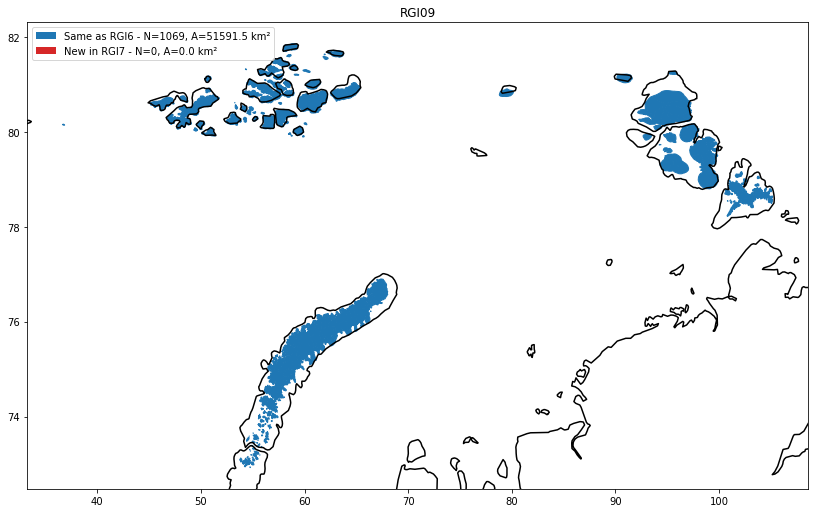

In [10]:
plot_map(rgi7, reg, loc='upper left', is_rgi6=True)

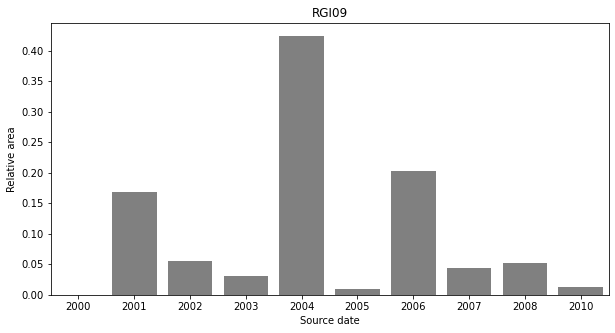

In [11]:
plot_date_hist(rgi7, reg)

### Text for github

In [12]:
fgh = sdf.T
fgh

subm_id,567
N,1069
A,51591.5
analysts,Moholdt
submitters,Koenig
release_date,2013
geog_area,"Svalbard, Jan Mayen, and Bouvet"
src_date_mode,2002
src_date_min,2000
src_date_max,2010


In [13]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 567                             |
|:--------------|:--------------------------------|
| N             | 1069                            |
| A             | 51591.5                         |
| analysts      | Moholdt                         |
| submitters    | Koenig                          |
| release_date  | 2013                            |
| geog_area     | Svalbard, Jan Mayen, and Bouvet |
| src_date_mode | 2002                            |
| src_date_min  | 2000                            |
| src_date_max  | 2010                            |


## Write out and tar 

In [14]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI09.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI09'], returncode=0)


## Consistency check with RGI6 

In [16]:
# load reference data
from utils import open_zip_shapefile
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [17]:
len(rgi7), len(rgi6)

(1069, 1069)

Test the areas:

In [18]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [19]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['area'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['area'].sum() - rgi7['area'].sum()) * 1e-6)

Area RGI7a (km2) 51591.52423020875
Area RGI6 (km2) 51591.6
Area RGI6 computed by us (km2) 51591.525007073666
diff areas RGI6 - RGI7 computed by us (km2) 0.0007768649139404297


The number of individual gaciers is the same! The total areas differ by only 777 m²...what else do we want?!